In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# 사전 훈련된 가중치 다운로드하기 - tmp 폴더 아래에 훈련된 가중치가 다운로드됨
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-01-25 10:05:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.212.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   232MB/s    in 0.4s    

2022-01-25 10:05:49 (232 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

'''
*** parameters

-- include_top: fcl 포함 여부 설정
-- weights: 적용할 가중치 지정
'''

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None) # 임의로 초기화된 가중치 적용

pre_trained_model.load_weights(local_weights_file) # 미리 다운로드한 가중치를 적용함

for layer in pre_trained_model.layers:
  layer.trainable = False # 뉴런 가중치의 훈련 가능 여부 설정함

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the ouptut layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2, 오버피팅을 피하기 위해 10개 중 2개의 뉴런은 학습에 참여시키지 않기
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 88.2MB/s]


In [ ]:
# os.path.join() 테스트
import os

print("join(): " + os.path.join("/A/B/C", "file.py"))

join(): /A/B/C/file.py


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import zipfile

# zipfile.ZipFile: zip 파일을 연다.
# -- 기존 파일을 읽으려면 r
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')

# 아카이브에서 현재 작업 디렉터리로 모든 멤버를 추출한다.
# tmp/안에 넣기
zip_ref.extractall('tmp/')

# 아카이브 파일을 닫는다. 프로그램을 종료하기 전에 close()를 호출해야 함
# 안닫으면 기록 안 됨
zip_ref.close()

# Define out example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

# os.path.join - 경로명 조작에 관한 처리를 하는 모듈
# 인수에 전달된 두 개의 문자열을 결합해서 1개의 경로로 만들기
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# os.listdir() - 지정한 디렉토리 내의 모든 파일과 디렉토리 이름의 리스트를 리턴한다. 
train_cat_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

### Add out data-augmentation parameters to ImageDataGenerator
- Validation data는 검증용도로 쓰는 것이므로 augmented 되면 안됨!

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size=(150, 150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100, # 훈련 샘플 수 / 배치 사이즈
    epochs = 20,
    validation_steps = 50, # 테스트 샘플 수 / 배치 사이즈
    verbose = 2
)

Epoch 1/20
100/100 - 142s - loss: 0.3695 - accuracy: 0.8550 - val_loss: 0.1326 - val_accuracy: 0.9500 - 142s/epoch - 1s/step
Epoch 2/20
100/100 - 133s - loss: 0.2179 - accuracy: 0.9130 - val_loss: 0.2263 - val_accuracy: 0.9250 - 133s/epoch - 1s/step
Epoch 3/20
100/100 - 133s - loss: 0.2137 - accuracy: 0.9215 - val_loss: 0.1282 - val_accuracy: 0.9540 - 133s/epoch - 1s/step
Epoch 4/20
100/100 - 133s - loss: 0.1774 - accuracy: 0.9355 - val_loss: 0.1439 - val_accuracy: 0.9530 - 133s/epoch - 1s/step
Epoch 5/20
100/100 - 133s - loss: 0.1869 - accuracy: 0.9295 - val_loss: 0.1157 - val_accuracy: 0.9590 - 133s/epoch - 1s/step
Epoch 6/20
100/100 - 134s - loss: 0.1861 - accuracy: 0.9310 - val_loss: 0.1116 - val_accuracy: 0.9590 - 134s/epoch - 1s/step
Epoch 7/20
100/100 - 133s - loss: 0.1593 - accuracy: 0.9410 - val_loss: 0.1092 - val_accuracy: 0.9650 - 133s/epoch - 1s/step
Epoch 8/20
100/100 - 134s - loss: 0.1871 - accuracy: 0.9380 - val_loss: 0.1103 - val_accuracy: 0.9600 - 134s/epoch - 1s/step


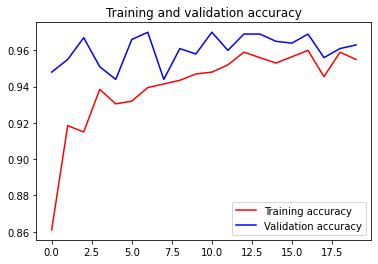

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()